<a href="https://colab.research.google.com/github/kumiori/variational-jumps/blob/main/notebooks/periodic-toughness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!rm -rf variational-jumps

!git clone https://github.com/kumiori/variational-jumps.git
sys.path.append("variational-jumps/src")

# %pip install -q git+https://github.com/kumiori/visuals.git



Cloning into 'variational-jumps'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 17), reused 24 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 337.47 KiB | 1.13 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [7]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import utils as u
import model as m


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
params = {"G0": 1.0, "G1": 2.0, "L0": 0.3, "L1": 0.7, "N": -1.0}

model = m.PeelingModel(params)
t_grid = np.linspace(0.0, 5.0, 300)
data = model.run_variational_flow(t_grid, l_0=0.1)
# data = model.run_global_minimizer(t_grid, l_0=0.1)
# data = model.run_energy_conserving(t_grid, l_0=0.1)

if data["l_path"] is None:
    print("No path found.")
else:
    print("Path found.")
# plt.plot(t_grid, data["l_path"])

# u.add_toughness_background(
#     ax=plt.gca(),
#     # x_max = max(data['l_path']),
#     x_max=10,
#     G0=model.G0,
#     G1=model.G1,
#     L0=model.L0,
#     L1=model.L1,
#     orientation="horizontal",
# )


Path found.


In [9]:
E_total = np.array(data["E_path"])
# Example: Normalize total energy to [0, 1]
normalized_energy = (E_total - np.min(E_total)) / (np.max(E_total) - np.min(E_total))
np.savetxt("../sound/energy_modulation.txt", normalized_energy, fmt="%.4f")

with open("../sound/energy_modulation_hs.txt", "w") as f:
    values = ", ".join(f"{v:.4f}" for v in normalized_energy)
    f.write(f"[{values}]")

In [10]:
model_evos = ["run_variational_flow", "run_energy_conserving", "run_global_minimizer"]
model_labels = ["Flow", "Conserve", "Minimiser"]

for label, method in zip(model_labels, model_evos):
    run_method = getattr(model, method)
    print(run_method)


<bound method PeelingModel.run_variational_flow of <model.PeelingModel object at 0x780e271e8490>>
<bound method PeelingModel.run_energy_conserving of <model.PeelingModel object at 0x780e271e8490>>
<bound method PeelingModel.run_global_minimizer of <model.PeelingModel object at 0x780e271e8490>>


In [11]:
data.keys()

dict_keys(['l_path', 't_grid', 'E_path', 'dissipation_path', 'drive_path', 'curvature_path'])

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact


# Dummy model computation (replace with your actual runner)
def run_evolutions_for_params(
    G0, gamma, rho, method="run_variational_flow", T_max=3.0, timesteps=200
):
    G1 = gamma * G0
    L0 = rho
    L1 = 1-rho
    # N = -1.0
    l_0 = 0.1

    params = {"G0": G0, "G1": G1, "L0": L0, "L1": L1, "N": -1.0}

    t_grid = np.linspace(0, T_max, timesteps)
    model = m.PeelingModel(params)
    run_method = getattr(model, method)
    data = run_method(t_grid, l_0=l_0)

    return data, params


@interact(
    gamma=widgets.FloatSlider(
        value=2.0, min=1.0, max=5.0, step=0.1, description="γ = G₁/G₀"
    ),
    rho=widgets.FloatSlider(
        value=.5, min=0.05, max=1.0, step=0.05, description="ρ = L₁/L₀"
    ),
)

def update_plot(gamma, rho):
    G0 = 1.

    data, params = run_evolutions_for_params(
        G0, gamma, rho, method="run_variational_flow"
    )
    t_grid = data["t_grid"]
    l_path = data["l_path"]
    p = params
    # print(data)
    runtime = np.nan
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(t_grid, l_path, label=f"Variational Flow", lw=7)
    u.add_toughness_background(ax, max(t_grid), p["G0"], p["G1"], p["L0"], p["L1"], alpha=.1, orientation="horizontal")
    ax.set_xlabel("Time $t$")
    ax.set_ylabel("Crack length $l(t)$")
    ax.set_title(f"Crack Evolution with $\\gamma = {gamma:.1f}$, $\\rho = {rho:.1f}$")

    ax.plot(
        t_grid,
        [np.sqrt(-p["N"] / (2 * p['G0'])) * t for t in t_grid],
        color="gray",
        linestyle="-",
        label="$l_0(t)$",
        alpha=0.5,
    )
    # ax[0].set_xlim(0, 7)
    ax.plot(
        t_grid,
        [np.sqrt(-p["N"] / (2 * p['G1'])) * t for t in t_grid],
        color="gray",
        linestyle="--",
        label="$l_1(t)$",
        alpha=0.5,
    )


    data, params = run_evolutions_for_params(
        G0, gamma, rho, method="run_energy_conserving"
    )
    t_grid = data["t_grid"]
    l_path = data["l_path"]
    ax.plot(t_grid, l_path, label=f"Energy conserving", lw=3)

    data, params = run_evolutions_for_params(
        G0, gamma, rho, method="run_global_minimizer"
    )
    t_grid = data["t_grid"]
    l_path = data["l_path"]
    ax.plot(t_grid, l_path, label=f"Global minimum", lw=3)

    plt.tight_layout()
    ax.legend()


interactive(children=(FloatSlider(value=2.0, description='γ = G₁/G₀', max=5.0, min=1.0), FloatSlider(value=0.5…

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy as sp
from scipy.optimize import root_scalar
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.patches import Rectangle


# Crack Propagation in Periodic Heterogeneous Substrates

This notebook investigates crack evolution in a thin film adhered to a rigid substrate with periodically varying fracture toughness. The film is perfectly flexible, inextensible, and initially bonded flat. Crack propagation is driven by a vertical displacement imposed at the boundary, coupled with constant horizontal tension.

We analyse the scenario where the substrate toughness alternates periodically between two values, $G_0$ and $G_1\geq G_0$, representing weak and strong adhesion zones, respectively. Our main goal is to explore how three different crack evolution criteria (nameyly, **variational flow**, **energy conservation**, and **global minimality**) affect the resulting crack evolution.

## Problem Setting

The total potential energy $E(\ell,t)$ of a film peeled up to a crack length $l$ at time $t$ is expressed as:

$$
E(l,t) = \frac{N t^2}{2l} + \int_0^l G_c(x)\,dx,
$$

with the periodic toughness distribution given by:

$$
G_c(x) =
\begin{cases}
G_0 & \text{if }\,\mathrm{mod}(x,L_0+L_1)<L_0,\\
G_1 & \text{otherwise.}
\end{cases}
$$

The crack evolution must fulfill the variational inequality conditions:

- Non-decreasing crack length $l(t)$.
- First-order stability conditions ensuring criticality.
- Second-order stability (positive second derivative of the energy) except at discrete jumps.
- Energy balance across jump transitions.

The numerical simulations conducted here solve this formulation explicitly, allowing comparison between different evolution criteria.

## Numerical Approach and Comparison of Criteria

We numerically solve the problem under three distinct crack growth criteria:

- **Variational Flow**: Local stability drives incremental crack growth, with jumps arising from instabilities resolved via gradient descent on energy.
- **Energy Conservation**: Crack propagation follows a global energy continuity principle, often allowing large jumps that bypass local toughness interfaces.
- **Global Minimality**: At each increment, the globally minimal energy state is selected, effectively homogenizing the toughness variations.

Each criterion reveals distinctive qualitative and quantitative characteristics, providing insights into crack propagation in heterogeneous materials.

In [15]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define model functions and labels
model_fns = [u.run_variational_flow, u.run_energy_conserving, u.run_global_minimizer]
model_labels = ["Flow", "Conserve", "Minimiser"]

# 2. Define a single parameter set
param_set = {
    "G0": 1.0,
    "G1": 2.0,
    "L0": 0.2,
    "L1": 0.8,
    "N": -1.0,
    "T_min": 0.0,
    "T_max": 3.0,
    "timesteps": 100,
    "l_0": 0.1,
}

G_avg = (param_set["G0"] * param_set["L0"] + param_set["G1"] * param_set["L1"]) / (
    param_set["L0"] + param_set["L1"]
)
_gamma = param_set["G0"] / param_set["G1"]
_rho = param_set["L0"] / param_set["L1"]

# 3. Collect results
results = []
evo_data = {}

for model_fn, label in zip(model_fns, model_labels):
    print(f"Running {label}...")
    kwargs = {}
    if label == "Minimiser":
        kwargs = {
            "l_max": 20,
        }
    start = time.time()
    data = u.run_evo_with_params(param_set, model_fn, kwargs)
    end = time.time()

    data["runtime"] = end - start
    evo_data[label] = data

    metrics = u.compute_metrics(data, label=label, tol=1e-1)
    metrics.update(param_set)
    metrics["runtime"] = end - start
    results.append(metrics)

# 4. Create DataFrame
df_single = pd.DataFrame(results)
print(df_single)


Running Flow...
Running Conserve...
Running Minimiser...
       label  final_length  max_jump  n_jumps             jump_sizes  \
0       Flow           1.5  0.216019        1  [0.21601896065819215]   
1   Conserve           1.5  0.386830        1  [0.38682966978156164]   
2  Minimiser           1.5  0.352000        1   [0.3520000000000004]   

   total_dissipation  avg_jump  var_jump   G0   G1   L0   L1    N  T_min  \
0           0.135838  0.216019       0.0  1.0  2.0  0.2  0.8 -1.0    0.0   
1           0.000000  0.386830       0.0  1.0  2.0  0.2  0.8 -1.0    0.0   
2           0.000000  0.352000       0.0  1.0  2.0  0.2  0.8 -1.0    0.0   

   T_max  timesteps  l_0   runtime  
0    3.0        100  0.1  0.003531  
1    3.0        100  0.1  0.015596  
2    3.0        100  0.1  3.897679  


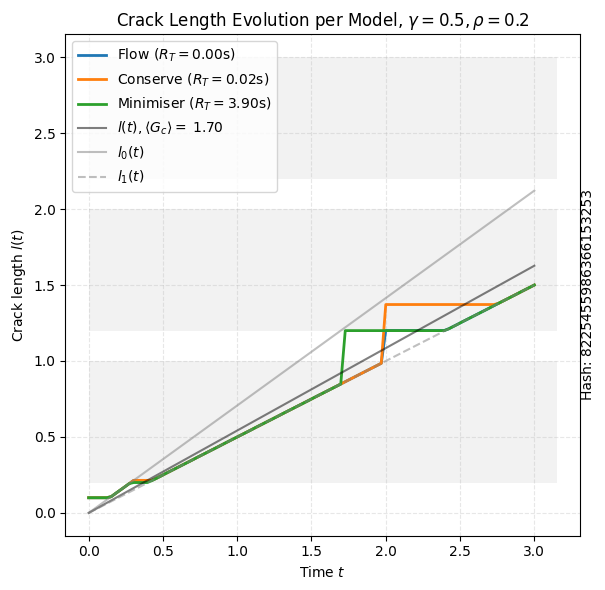

In [16]:
N_val = param_set["N"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for label, data in evo_data.items():
    ax.plot(
        data["t_grid"],
        data["l_path"],
        label=f"{label} ($R_T={data['runtime']:.2f}$s)",
        lw=2,
    )
u.add_toughness_background(
    ax,
    x_max=max(data["t_grid"]),
    G0=param_set["G0"],
    G1=param_set["G1"],
    L0=param_set["L0"],
    L1=param_set["L1"],
    alpha=0.05,
    orientation="horizontal",
)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Crack length $l(t)$")

ax.set_title(
    f"Crack Length Evolution per Model, $\\gamma = {_gamma:.1f}, \\rho = {_rho:.1f}$"
)

_hash = hash(f"{param_set['G0']}_{param_set['G1']}_{param_set['L0']}_{param_set['L1']}")
ax.grid(True, linestyle="--", alpha=0.3)

fig.tight_layout()
fig.show()
t_grid = data["t_grid"]

G_avg = (params["G0"] * params["L0"] + params["G1"] * params["L1"]) / (
    params["L0"] + params["L1"]
)

ax.plot(
    t_grid,
    [np.sqrt(-N_val / (2 * G_avg)) * t for t in t_grid],
    color="k",
    linestyle="-",
    label=f"$l(t), \\langle G_c \\rangle =$ {G_avg:.2f}",
    alpha=0.5,
)

ax.plot(
    t_grid,
    [np.sqrt(-N_val / (2 * data["params"]["G0"])) * t for t in t_grid],
    color="gray",
    linestyle="-",
    label="$l_0(t)$",
    alpha=0.5,
)
# ax[0].set_xlim(0, 7)
ax.plot(
    t_grid,
    [np.sqrt(-N_val / (2 * data["params"]["G1"])) * t for t in t_grid],
    color="gray",
    linestyle="--",
    label="$l_1(t)$",
    alpha=0.5,
)
ax.legend()

fig.tight_layout()
# add hash text annotation on right side vertical

fig.text(
    1.0,
    0.5,
    f"Hash: {_hash}",
    fontsize=10,
    ha="right",
    va="center",
    rotation=90,
    # bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)
fig.savefig(f"crack_length_evolution-{_hash}.pdf", dpi=300)


In [17]:
evo_data.keys()

dict_keys(['Flow', 'Conserve', 'Minimiser'])

Variational Flow
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842

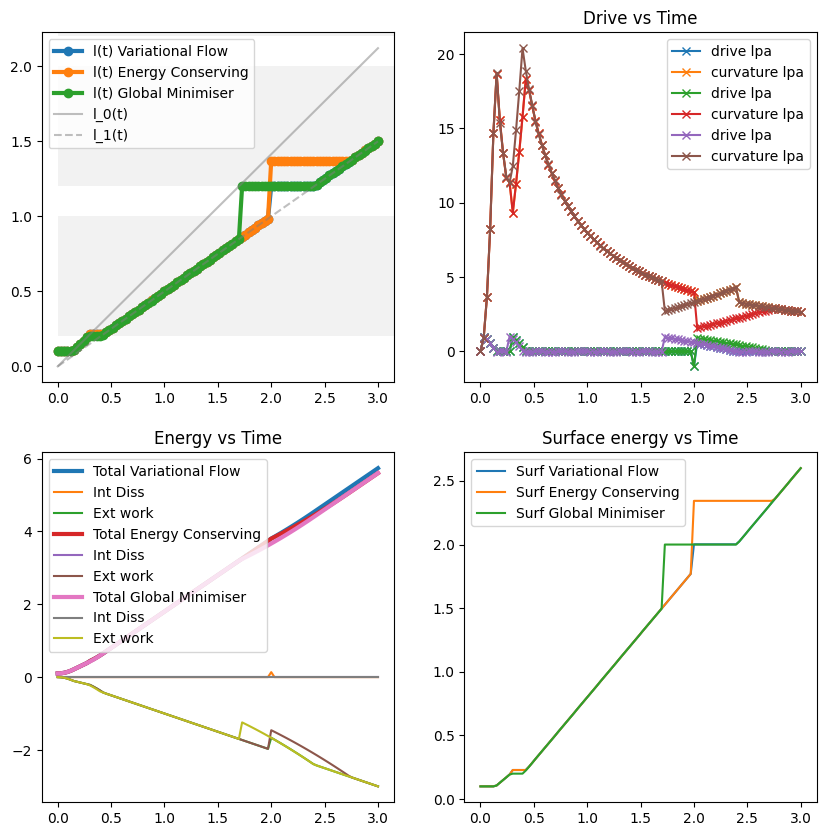

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

evo_variational_flow = evo_data["Flow"]
evo_conserving = evo_data["Conserve"]
evo_global = evo_data['Minimiser']


for evo, label in zip(
    [evo_variational_flow, evo_conserving, evo_global],
    ["Variational Flow", "Energy Conserving", "Global Minimiser"],
):
    print(label)
    l_path = evo["l_path"]
    t_grid = evo["t_grid"]
    E_path = evo["E_path"]

    dissipation_path = evo["dissipation_path"]
    print(dissipation_path)
    drive_path = evo["drive_path"]
    curvature_path = evo["curvature_path"]
    ext_work = N_val * t_grid**2 / (2 * l_path)

    ax[0].plot(t_grid, l_path, label=f"l(t) {label}", lw=3, marker="o")

    ax[1].plot(t_grid, drive_path, label="drive lpa", marker="x")
    ax[1].plot(t_grid, curvature_path, label="curvature lpa", marker="x")
    ax[1].set_title("Drive vs Time")
    ax[1].legend()

    ax[2].plot(t_grid, (E_path + dissipation_path), label=f"Total {label}", lw=3)
    ax[2].plot(t_grid, np.diff(dissipation_path, prepend=0), label="Int Diss")
    ax[2].plot(t_grid, ext_work, label="Ext work")
    # ax[2].plot(t_grid, compute_surface_energy(l_path), label="Surf")
    ax[2].set_title("Energy vs Time")

    ax[3].plot(t_grid, u.compute_surface_energy(l_path), label=f"Surf {label}")
    ax[3].set_title("Surface energy vs Time")

G0_val = evo_variational_flow["params"]["G0"]
G1_val = evo_variational_flow["params"]["G1"]
L0_val = evo_variational_flow["params"]["L0"]
L1_val = evo_variational_flow["params"]["L1"]

ax[0].plot(
    t_grid,
    [np.sqrt(-N_val / (2 * G0_val)) * t for t in t_grid],
    color="gray",
    linestyle="-",
    label="l_0(t)",
    alpha=0.5,
)
# ax[0].set_xlim(0, 7)
ax[0].plot(
    t_grid,
    [np.sqrt(-N_val / (2 * G1_val)) * t for t in t_grid],
    color="gray",
    linestyle="--",
    label="l_1(t)",
    alpha=0.5,
)
[_ax.legend() for _ax in ax]
u.add_toughness_background(
    ax[0],
    x_max=max(t_grid),
    G0=G0_val,
    G1=G1_val,
    L0=L0_val,
    L1=L1_val,
    alpha=0.05,
    orientation="horizontal",
)


In [22]:
evo_variational_flow;

In [20]:


l_path_conseravation = evo_data["Conserve"]["l_path"]
l_path_flow = evo_data["Flow"]["l_path"]
l_path_global = evo_data["Minimiser"]["l_path"]
l_vals = np.linspace(0.1, max(l_path_flow), 300)

slider = widgets.IntSlider(value=0, min=0, max=99, step=1, description="Step")
play = widgets.Play(
    interval=200, value=0, min=0, max=99, step=1, description="Press play"
)

widgets.jslink((play, "value"), (slider, "value"))


@interact(
    t=widgets.FloatSlider(
        value=1.0,
        min=min(t_grid),
        max=max(t_grid),
        step=t_grid[1] - t_grid[0],
        description="Load t",
    )
    # t=widgets.FloatSlider(value=1.0, min=0.1, max=7.0, step=0.1, description="Load t")
)
def update_plot(t):
    E_vals = u.compute_energy(l_vals, t_val=t)
    l_minus = np.sqrt(-N_val * t**2 / (2 * np.max([G0_val, G1_val])))
    dE_dl = u.compute_energy_derivative(l_vals, side="right")
    l_t = u.l_vs_t(l_path_flow, t_grid, t)
    l_t_cons = u.l_vs_t(l_path_conseravation, t_grid, t)
    l_t_glob = u.l_vs_t(l_path_global, t_grid, t)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(l_vals, E_vals, label=f"$E(l) at t={t:.1f}$")
    ax[0].set_title("Peeling Energy E(l) vs Crack Length l")
    ax[0].set_xlabel("l")
    ax[0].scatter(
        l_minus, u.compute_energy(l_minus, t_val=t), color="red", label="$l^-$", s=100
    )
    ax[0].scatter(l_t, u.compute_energy(l_t, t_val=t), color="k", label="$l_t$", s=70)
    ax[0].scatter(
        l_t_cons, u.compute_energy(l_t_cons, t_val=t), color="C1", label="$l_c$", s=30
    )
    ax[0].scatter(
        l_t_glob,
        u.compute_energy(l_t_glob, t_val=t),
        color="C2",
        label="$l_g$",
        s=30,
        marker="s",
    )
    ax[0].set_ylabel("E(l)")
    # ax[0].grid(True)
    ax[0].set_ylim((1 - 0.03) * min(E_vals), (1 + 0.1) * min(E_vals))
    ax[0].axhline(min(E_vals), color="gray", linestyle="-", label="min $E$")
    ticks = [min(E_vals), int(min(E_vals) + 1)]
    tick_labels = [f"min E = {ticks[0]:.1f}", f"{ticks[1]:.0f}"]
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(tick_labels)

    # ax[0].set_ylim(-1, 1)
    ax[0].legend()

    ax[1].plot(l_vals, dE_dl, label="$E'(l^-)$", linestyle="-")
    ax[1].scatter(
        l_minus,
        u.compute_energy_derivative(l_minus, side="right"),
        color="red",
        s=100,
        label="$l^-$",
    )
    ax[1].scatter(
        l_t_cons,
        u.compute_energy_derivative(l_t_cons, side="right"),
        color="C1",
        label="$l_t$",
        s=30,
    )
    ax[1].scatter(
        l_t,
        u.compute_energy_derivative(l_t, side="right"),
        color="k",
        label="$l_t$",
        s=30,
    )
    ax[1].scatter(
        l_t_glob,
        u.compute_energy_derivative(l_t_glob, side="right"),
        color="C2",
        label="$l_g$",
        s=30,
        marker="s",
    )
    ax[1].set_title("(Right) Derivative $E'(l)$ for Binary Periodic Toughness")
    ax[1].set_ylim(-0, 3)

    for _ax in ax:
        u.add_toughness_background(
            _ax,
            x_max=max(l_path_flow),
            G0=G0_val,
            G1=G1_val,
            L0=L0_val,
            L1=L1_val,
            orientation="vertical",
            alpha=0.05,
        )

    plt.tight_layout()
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='Load t', max=3.0, step=0.030303030303030304), Output…

In [21]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# === Setup slider + play widget ===
slider = widgets.IntSlider(
    value=0, min=0, max=len(t_grid) - 1, step=1, description="Step"
)
play = widgets.Play(
    interval=200, value=0, min=0, max=len(t_grid) - 1, step=1, description="Play"
)

# Step buttons
step_back = widgets.Button(description="◀ Step Back")
step_fwd = widgets.Button(description="Step Fwd ▶")


# Update slider on button click
def on_step_back(b):
    if slider.value > slider.min:
        slider.value -= 1


def on_step_fwd(b):
    if slider.value < slider.max:
        slider.value += 1


step_back.on_click(on_step_back)
step_fwd.on_click(on_step_fwd)

widgets.jslink((play, "value"), (slider, "value"))

# === Interactive plot using the step index ===
@widgets.interact(idx=slider)
def update_plot(idx):
    t = t_grid[idx]
    E_vals = u.compute_energy(l_vals, t_val=t)
    dE_dl = u.compute_energy_derivative(l_vals, side="right")
    l_t = u.l_vs_t(l_path_flow, t_grid, t)
    l_t_cons = u.l_vs_t(l_path_conseravation, t_grid, t)
    l_t_glob = u.l_vs_t(l_path_global, t_grid, t)

    fig, ax = plt.subplots(1, 2, figsize=(10, 8))

    # Plot energy
    ax[0].plot(l_vals, E_vals, label=f"$E(l)$ at $t={t:.1f}$", lw=2)
    ax[0].scatter(l_t, u.compute_energy(l_t, t_val=t), color="k", label="$l_t$", s=200)
    ax[0].scatter(
        l_t_cons, u.compute_energy(l_t_cons, t_val=t), color="C1", label="$l_c$", s=100
    )
    ax[0].scatter(
        l_t_glob,
        u.compute_energy(l_t_glob, t_val=t),
        color="C2",
        label="$l_g$",
        s=100,
        marker="s",
    )
    ax[0].set_title("Peeling Energy $E(l)$ vs $l$")
    ax[0].set_xlabel("Crack length $l$")
    ax[0].set_ylabel("$E(l)$")
    ax[0].axhline(min(E_vals), color="gray", linestyle="--", label="min $E$")
    ax[0].legend()

    # Plot derivative
    ax[1].plot(l_vals, dE_dl, label="$E'(l^-)$", linestyle="-", lw=2)
    ax[1].scatter(
        l_t,
        u.compute_energy_derivative(l_t, side="right"),
        color="k",
        s=200,
        label="$l_t$",
    )
    ax[1].scatter(
        l_t_cons,
        u.compute_energy_derivative(l_t_cons, side="right"),
        color="C1",
        s=100,
        label="$l_c$",
    )
    ax[1].scatter(
        l_t_glob,
        u.compute_energy_derivative(l_t_glob, side="right"),
        color="C2",
        s=100,
        marker="s",
        label="$l_g$",
    )
    ax[1].set_title("Right Derivative $E'(l)$")
    ax[1].set_ylim(-0.1, 3.1)
    l0_val = .1
    ax[1].axvline(
        l0_val, color="k", linestyle="-", label="$l_0$",
    )
    ax[1].legend()
    for _ax in ax:
        u.add_toughness_background(
            _ax,
            x_max=max(l_path_flow),
            G0=G0_val,
            G1=G1_val,
            L0=L0_val,
            L1=L1_val,
            orientation="vertical",
            alpha=0.05,
        )

    plt.tight_layout()
    plt.show()


# Display controls manually
widgets.HBox([play, slider])
display(widgets.HBox([play, slider, step_back, slider, step_fwd]))

interactive(children=(IntSlider(value=0, description='Step', max=99), Output()), _dom_classes=('widget-interac…